# Development

All code here is experimental. Please see README for current usage instructions.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, mean_absolute_percentage_error

from forecastiso.data_loader import ISODataLoader
from forecastiso.features import (
    FeatureManager,
    LagFeatureGenerator,
    RollingFeatureGenerator,
    CalendarFeatureGenerator,
    InteractionFeatureGenerator,
)
from forecastiso.forecasters import SimpleXGBForecaster, WindowedXGBForecaster

# plt.style.use("seaborn-v0_8-paper")
# plt.style.use("bmh")

In [3]:
df = pd.read_pickle("../data/caiso_hourly/preprocessed_hourly_load.pkl")
df.head()

,datetime,area,load
0,2022-01-01 00:00:00,caiso,22303.67
1,2022-01-01 01:00:00,caiso,21491.08
2,2022-01-01 02:00:00,caiso,21041.72
3,2022-01-01 03:00:00,caiso,20875.96
4,2022-01-01 04:00:00,caiso,20901.42


In [4]:
# limit to one area
df = df[df["area"] == "caiso"]
df = df.drop(columns=["area"])

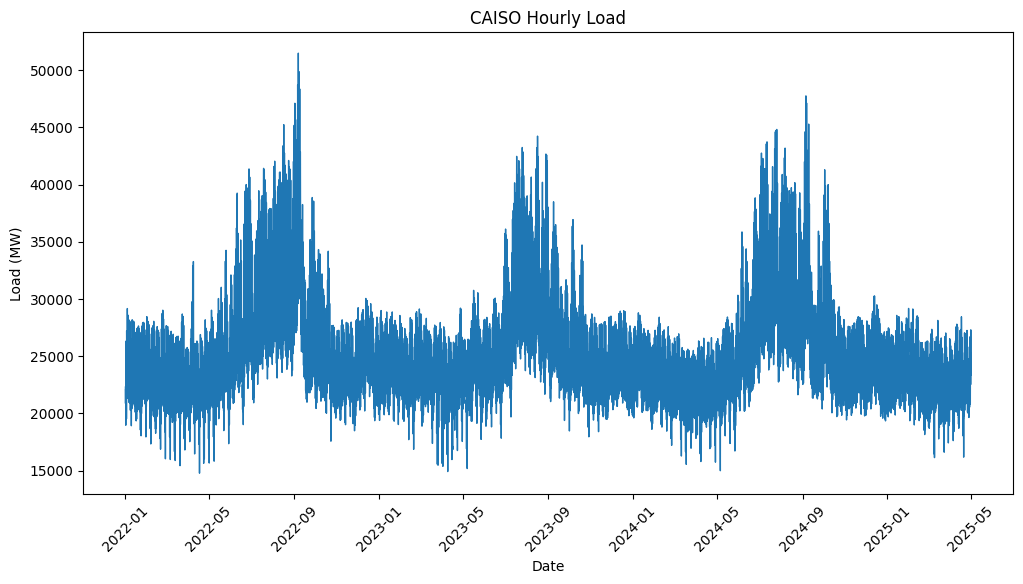

In [5]:
# line plot
plt.figure(figsize=(12, 6))
plt.plot(df["datetime"], df["load"], label="Load", linewidth=1)
plt.title("CAISO Hourly Load")
plt.xlabel("Date")
plt.ylabel("Load (MW)")
plt.xticks(rotation=45)
plt.show()

In [6]:
# filter for a specific date range
start_date = "2022-01-01"
predict_date = "2025-02-12"
df_filtered = df[(df["datetime"] >= start_date) & (df["datetime"] < predict_date)]

ground_truth = df[df["datetime"].dt.strftime("%Y-%m-%d") == predict_date]["load"].reset_index(drop=True)

In [7]:
df_filtered.head()

,datetime,load
0,2022-01-01 00:00:00,22303.67
1,2022-01-01 01:00:00,21491.08
2,2022-01-01 02:00:00,21041.72
3,2022-01-01 03:00:00,20875.96
4,2022-01-01 04:00:00,20901.42


In [8]:
# generate features

fm = FeatureManager()
fm.add_generator(LagFeatureGenerator(lags=[24, 48, 168]))
fm.add_generator(RollingFeatureGenerator(windows=[24, 168, 720]))
fm.add_generator(CalendarFeatureGenerator())
# fm.add_generator(InteractionFeatureGenerator([["hour", "day_before_weekend"]]))

features_df = fm.generate_features(df_filtered)

print(features_df.shape)
print(features_df.columns)
# print(features_df.dtypes)

(27120, 39)
Index(['load', 'load_lag_24', 'load_lag_48', 'load_lag_168',
       'load_rolling_mean_24', 'load_rolling_std_24', 'load_rolling_min_24',
       'load_rolling_max_24', 'load_rolling_mean_168', 'load_rolling_std_168',
       'load_rolling_min_168', 'load_rolling_max_168', 'load_rolling_mean_720',
       'load_rolling_std_720', 'load_rolling_min_720', 'load_rolling_max_720',
       'hour', 'dow', 'month', 'day', 'quarter', 'year', 'doy', 'is_weekend',
       'day_before_weekend', 'is_holiday', 'day_before_holiday',
       'day_after_holiday', 'target_dow', 'target_month', 'target_day',
       'target_quarter', 'target_year', 'target_doy', 'target_is_weekend',
       'target_day_before_weekend', 'target_is_holiday',
       'target_day_before_holiday', 'target_day_after_holiday'],
      dtype='object')


In [9]:
features_df.head()

,load,load_lag_24,load_lag_48,load_lag_168,load_rolling_mean_24,load_rolling_std_24,load_rolling_min_24,load_rolling_max_24,load_rolling_mean_168,load_rolling_std_168,...,target_month,target_day,target_quarter,target_year,target_doy,target_is_weekend,target_day_before_weekend,target_is_holiday,target_day_before_holiday,target_day_after_holiday
datetime,,,,,,,,,,,,,,,,,,,,,
2022-01-08 00:00:00,21912.76,21860.77,22062.32,22303.67,24652.200417,2182.118521,20885.12,28000.04,23964.045298,2416.298229,...,1.0,9.0,1.0,2022.0,9.0,True,False,False,False,False
2022-01-08 01:00:00,21036.66,21258.54,21371.16,21491.08,24642.955417,2197.537147,20885.12,28000.04,23961.340417,2419.335559,...,1.0,9.0,1.0,2022.0,9.0,True,False,False,False,False
2022-01-08 02:00:00,20592.94,20953.51,20988.03,21041.72,24627.931667,2224.919139,20592.94,28000.04,23958.669107,2422.823807,...,1.0,9.0,1.0,2022.0,9.0,True,False,False,False,False
2022-01-08 03:00:00,20278.53,20885.12,20966.12,20875.96,24602.657083,2272.227632,20278.53,28000.04,23955.112976,2427.808901,...,1.0,9.0,1.0,2022.0,9.0,True,False,False,False,False
2022-01-08 04:00:00,20513.13,21461.29,21425.53,20901.42,24563.150417,2336.552732,20278.53,28000.04,23952.801726,2430.916230,...,1.0,9.0,1.0,2022.0,9.0,True,False,False,False,False


In [10]:
# forecaster = LinearRegressionForecaster(
#     feature_cols=["load_lag_24", "load_lag_48", "load_lag_168",
#                   "load_rolling_mean_24", "load_rolling_mean_168", "load_rolling_mean_720",
#                   "hour", "month", "dayofweek", "is_weekend", "day", "quarter", "hour_is_weekend"],
#     target_col="load",
#     standardize=False,
#     # use_ridge=True,
#     # alpha=1.0,
# )

# forecaster.fit(features_df)

# prediction = forecaster.predict(horizon=24)


In [11]:
# prediction

In [12]:
# plt.figure(figsize=(12, 6))
# plt.plot(ground_truth, label="Ground Truth", linewidth=1)
# plt.plot(prediction, label="Prediction", linewidth=1)
# plt.legend()
# plt.show()

In [13]:
simple_xgb = SimpleXGBForecaster(
    feature_cols=["load_lag_24", "load_lag_48", "load_lag_168",
                 "load_rolling_mean_24", "load_rolling_min_24", "load_rolling_max_24", "load_rolling_std_24",
                 "load_rolling_mean_168", "load_rolling_min_168", "load_rolling_max_168", "load_rolling_std_168",
                 "load_rolling_mean_720", "load_rolling_min_720", "load_rolling_max_720", "load_rolling_std_720",
                 "hour", "target_month", "target_dow", "target_doy", "target_is_holiday", "target_day_before_holiday", "target_is_weekend", 
                 "target_day", "target_quarter", "target_year"],
    target_col="load",
    # n_estimators=300,
    max_depth=6,
)

simple_xgb.fit(features_df)

# prediction = simple_xgb.predict(horizon=24)

In [14]:
windowed_xgb = WindowedXGBForecaster(
    target_col="load",
    feature_cols=["load_lag_24", "load_lag_48", "load_lag_168",
                   "load_rolling_mean_24", "load_rolling_min_24", "load_rolling_max_24", "load_rolling_std_24",
                   "load_rolling_mean_168", "load_rolling_min_168", "load_rolling_max_168", "load_rolling_std_168",
                   "load_rolling_mean_720", "load_rolling_min_720", "load_rolling_max_720", "load_rolling_std_720",
                   "hour", "target_month", "target_dow", "target_doy", "target_is_holiday", "target_day_before_holiday", "target_is_weekend", 
                   "target_day", "target_quarter", "target_year"],
    max_depth=6,
    # n_estimators=300,
)

windowed_xgb.fit(features_df)
# windowed_xgb.fit(features_df_copy)

# prediction = windowed_xgb.predict(horizon=24)

In [15]:
# ph_xgb = PerHourXGBForecaster(
#     target_col="load",
#     feature_cols=["load_lag_24", "load_lag_48", "load_lag_168",
#                    "load_rolling_mean_24", "load_rolling_min_24", "load_rolling_max_24", "load_rolling_std_24",
#                    "load_rolling_mean_168", "load_rolling_min_168", "load_rolling_max_168", "load_rolling_std_168",
#                    "load_rolling_mean_720", "load_rolling_min_720", "load_rolling_max_720", "load_rolling_std_720",
#                    "hour", "target_month", "target_dow", "target_doy", "target_is_holiday", "target_day_before_holiday", "target_is_weekend", 
#                    "target_day", "target_quarter", "target_year"],
#     max_depth=6,
# )

# ph_xgb.fit(features_df)
# prediction = ph_xgb.predict(horizon=24)

In [16]:
features_df = fm.generate_features(df)

# features_df["load_lag_24"] = features_df["load"].shift(23)
# features_df["load_lag_48"] = features_df["load"].shift(47)
# features_df["load_lag_168"] = features_df["load"].shift(167)

In [17]:
features_df.head()

,load,load_lag_24,load_lag_48,load_lag_168,load_rolling_mean_24,load_rolling_std_24,load_rolling_min_24,load_rolling_max_24,load_rolling_mean_168,load_rolling_std_168,...,target_month,target_day,target_quarter,target_year,target_doy,target_is_weekend,target_day_before_weekend,target_is_holiday,target_day_before_holiday,target_day_after_holiday
datetime,,,,,,,,,,,,,,,,,,,,,
2022-01-08 00:00:00,21912.76,21860.77,22062.32,22303.67,24652.200417,2182.118521,20885.12,28000.04,23964.045298,2416.298229,...,1.0,9.0,1.0,2022.0,9.0,True,False,False,False,False
2022-01-08 01:00:00,21036.66,21258.54,21371.16,21491.08,24642.955417,2197.537147,20885.12,28000.04,23961.340417,2419.335559,...,1.0,9.0,1.0,2022.0,9.0,True,False,False,False,False
2022-01-08 02:00:00,20592.94,20953.51,20988.03,21041.72,24627.931667,2224.919139,20592.94,28000.04,23958.669107,2422.823807,...,1.0,9.0,1.0,2022.0,9.0,True,False,False,False,False
2022-01-08 03:00:00,20278.53,20885.12,20966.12,20875.96,24602.657083,2272.227632,20278.53,28000.04,23955.112976,2427.808901,...,1.0,9.0,1.0,2022.0,9.0,True,False,False,False,False
2022-01-08 04:00:00,20513.13,21461.29,21425.53,20901.42,24563.150417,2336.552732,20278.53,28000.04,23952.801726,2430.916230,...,1.0,9.0,1.0,2022.0,9.0,True,False,False,False,False


Fitting and evaluating model for 2025-02-26 00:00:00
Predicting for 2025-02-26 00:00:00 with latest row at 2025-02-25 23:00:00


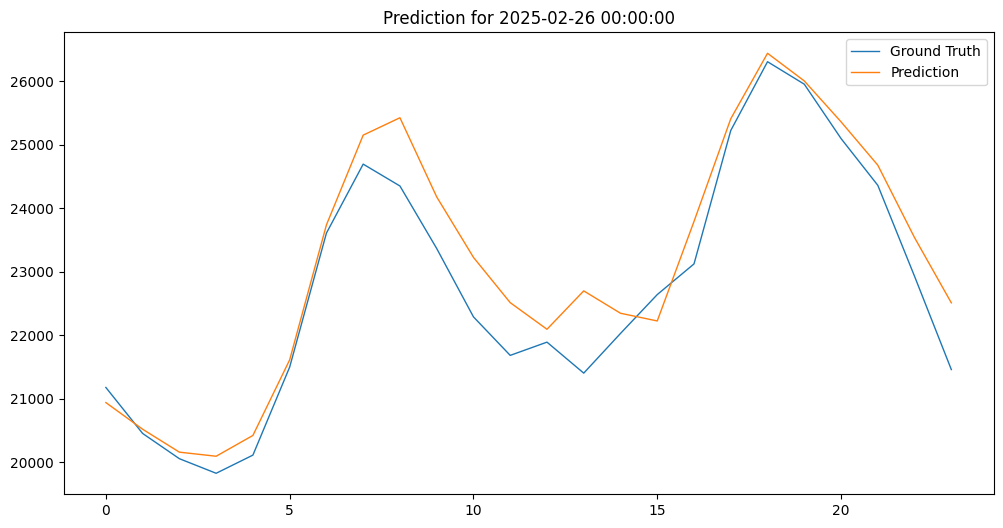

MAPE for 2025-02-26 00:00:00: 0.01949144841668785
MAE for 2025-02-26 00:00:00: 452.30311606981286
RMSE for 2025-02-26 00:00:00: 577.6905181034567
-------

Fitting and evaluating model for 2025-02-27 00:00:00
Predicting for 2025-02-27 00:00:00 with latest row at 2025-02-26 23:00:00


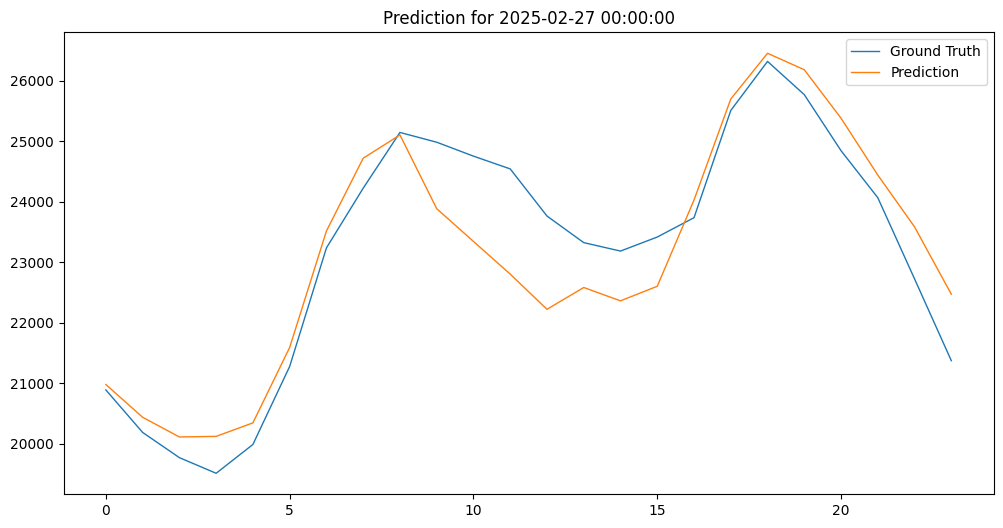

MAPE for 2025-02-27 00:00:00: 0.027037809982914784
MAE for 2025-02-27 00:00:00: 618.0893593625125
RMSE for 2025-02-27 00:00:00: 770.9360584085272
-------

Fitting and evaluating model for 2025-02-28 00:00:00
Predicting for 2025-02-28 00:00:00 with latest row at 2025-02-27 23:00:00


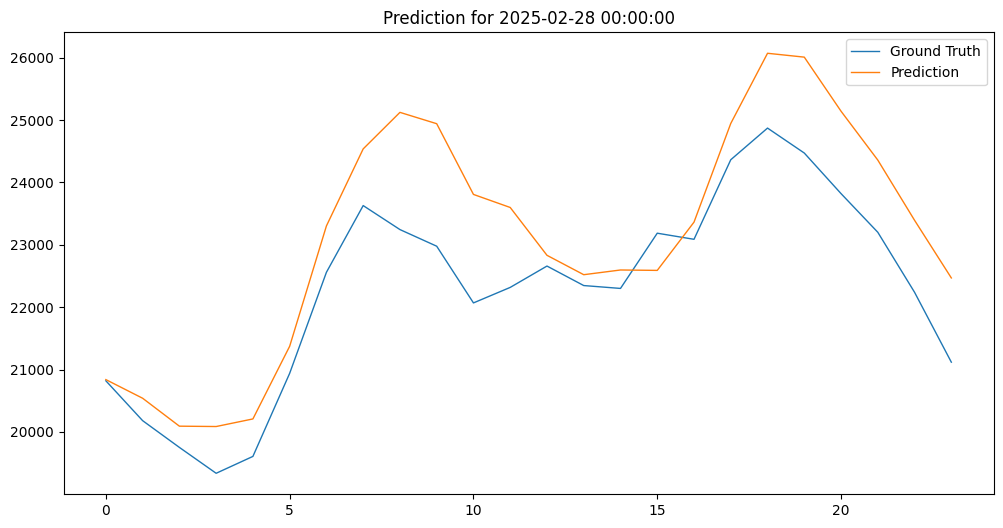

MAPE for 2025-02-28 00:00:00: 0.03653529550080292
MAE for 2025-02-28 00:00:00: 867.8944720677124
RMSE for 2025-02-28 00:00:00: 1035.5831965048058
-------

Fitting and evaluating model for 2025-03-01 00:00:00
Predicting for 2025-03-01 00:00:00 with latest row at 2025-02-28 23:00:00


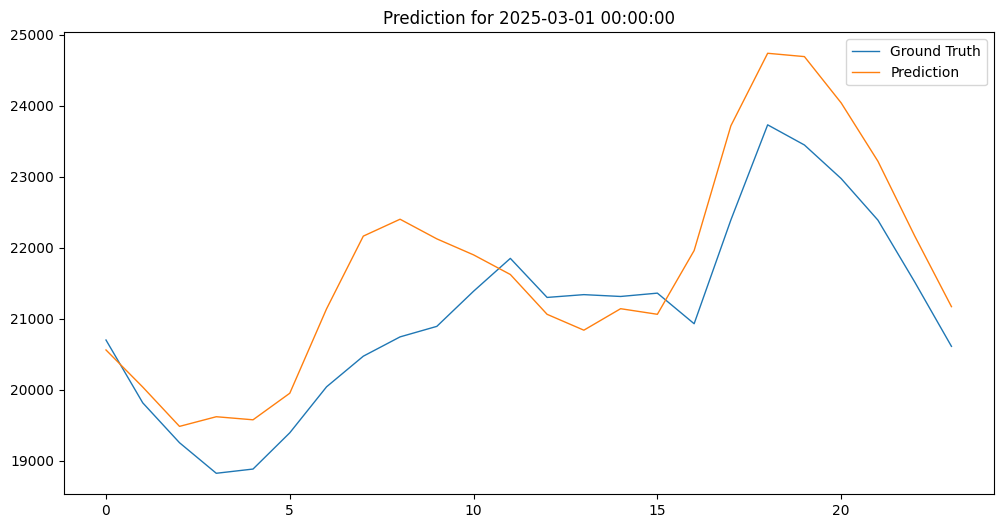

MAPE for 2025-03-01 00:00:00: 0.03386784883490002
MAE for 2025-03-01 00:00:00: 749.1228193166667
RMSE for 2025-03-01 00:00:00: 879.4340963861598
-------

Fitting and evaluating model for 2025-03-02 00:00:00
Predicting for 2025-03-02 00:00:00 with latest row at 2025-03-01 23:00:00


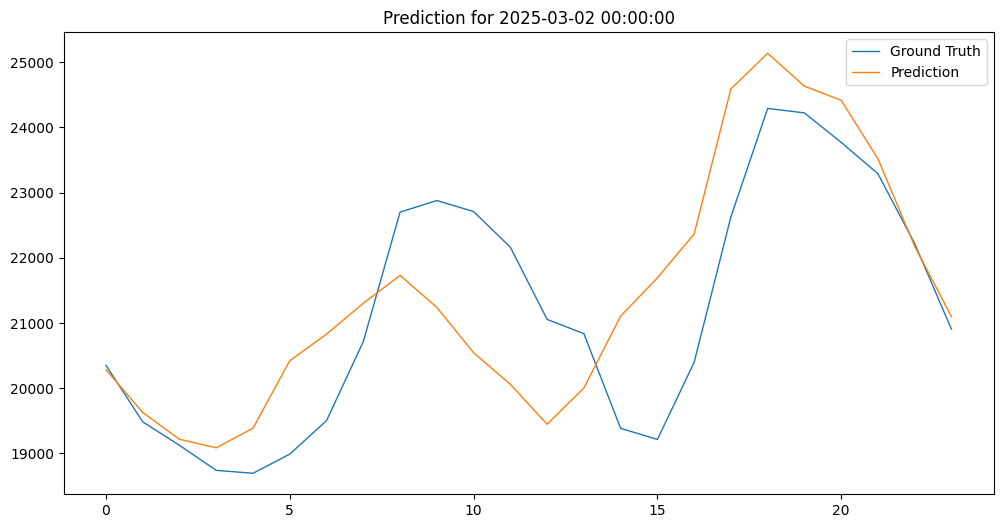

MAPE for 2025-03-02 00:00:00: 0.047855774431967514
MAE for 2025-03-02 00:00:00: 1021.2301616564667
RMSE for 2025-03-02 00:00:00: 1275.790299201223
-------

Fitting and evaluating model for 2025-03-03 00:00:00
Predicting for 2025-03-03 00:00:00 with latest row at 2025-03-02 23:00:00


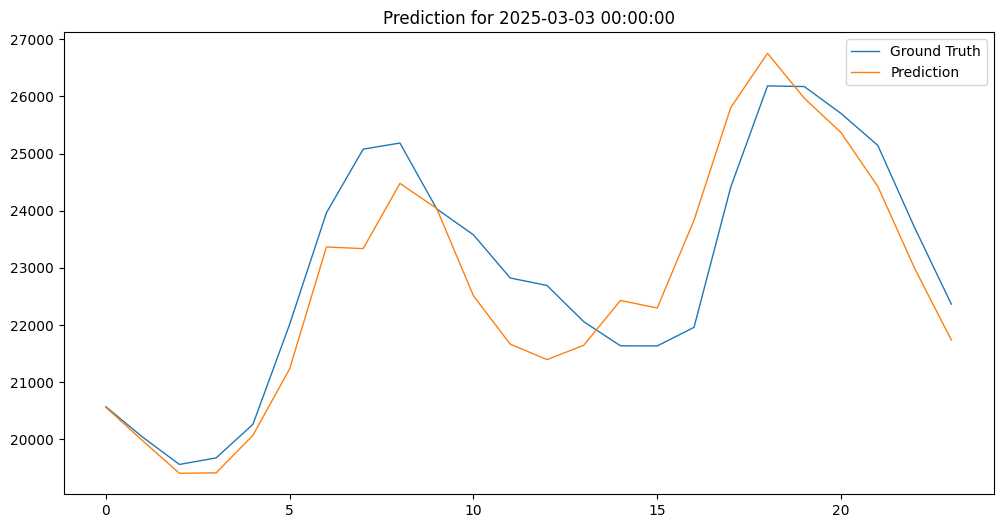

MAPE for 2025-03-03 00:00:00: 0.029600561701019722
MAE for 2025-03-03 00:00:00: 680.6370087697954
RMSE for 2025-03-03 00:00:00: 850.6811226507187
-------

Fitting and evaluating model for 2025-03-04 00:00:00
Predicting for 2025-03-04 00:00:00 with latest row at 2025-03-03 23:00:00


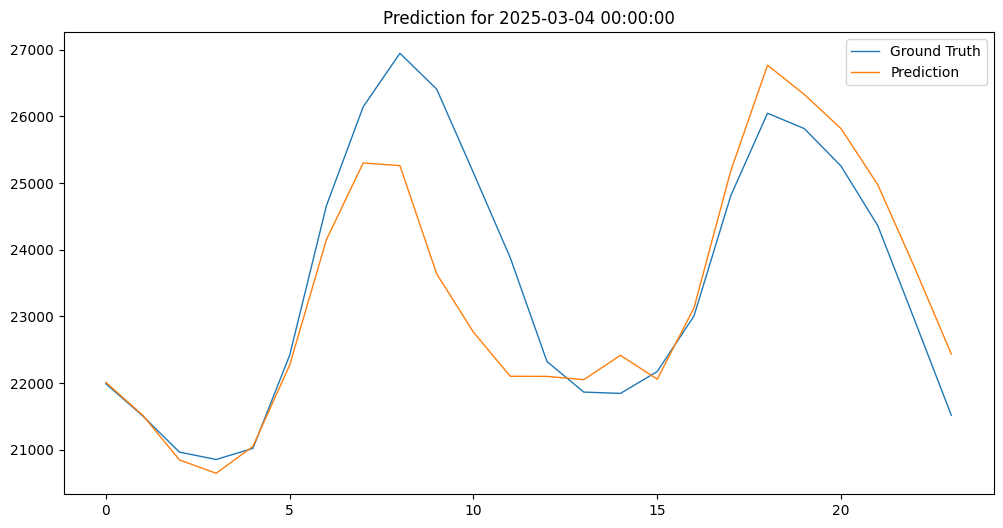

MAPE for 2025-03-04 00:00:00: 0.02852319637858164
MAE for 2025-03-04 00:00:00: 675.1187280635503
RMSE for 2025-03-04 00:00:00: 998.5570570574882
-------

0.03184456217812492


In [ ]:
predict_date = "2025-02-12"

predictions = []
mape_list = []

# evaluate predictions and plot for 7 days
for i in range(7):

    # at 00:00 hours
    cur_predict_date = pd.to_datetime(predict_date) + pd.Timedelta(days=i)
    cur_day_before_date = pd.to_datetime(predict_date) + pd.Timedelta(days=i-1)

    # data for the day we are predicting
    predict_df = features_df[cur_predict_date:cur_predict_date + pd.Timedelta(hours=23)]
    y_true = predict_df["load"].reset_index(drop=True)
    # print(y_true.tail())
    # print(y_true.shape)

    # filter by predict_date using datetime index
    print(f"Fitting and evaluating model for {cur_predict_date}")

    # simple_xgb = SimpleXGBForecaster(
    #     feature_cols=["load_lag_24", "load_lag_48", "load_lag_168",
    #                 "load_rolling_mean_24", "load_rolling_min_24", "load_rolling_max_24", "load_rolling_std_24",
    #                 "load_rolling_mean_168", "load_rolling_min_168", "load_rolling_max_168", "load_rolling_std_168",
    #                 "load_rolling_mean_720", "load_rolling_min_720", "load_rolling_max_720", "load_rolling_std_720",
    #                 "hour", "month", "dayofweek", "dayofyear", "is_holiday", "day_before_holiday", "is_weekend", 
    #                 "day", "quarter", "year", "hour_is_weekend"],
    #     target_col="load",
    #     # n_estimators=300,
    #     max_depth=6,
    # )
    # simple_xgb.fit(cur_features_df)
    # predict_features_df = fm.generate_features(predict_df)

    # take latest row as pandas series and df for windowed version
    day_before_df = features_df[cur_day_before_date:cur_day_before_date + pd.Timedelta(hours=23)]
    latest_row = day_before_df.iloc[-1]
    latest_datetime = day_before_df.index[-1]
    latest_day_df = day_before_df[latest_datetime - pd.Timedelta(hours=23):latest_datetime]
    # print(latest_day_df.shape)
    # print(latest_day_df.head().index)
    # print(latest_day_df.index)

    # check temporal alignment
    print(f"Predicting for {cur_predict_date} with latest row at {latest_datetime}")

    # check if target_dow matches the predict dow
    if latest_row["target_dow"] != cur_predict_date.dayofweek:
        print(f"Warning: target_dow {latest_row['target_dow']} does not match predict dow {cur_predict_date.dayofweek}")
    
    # inference
    # y_pred = simple_xgb.predict(horizon=24, external_features=latest_row)
    y_pred = windowed_xgb.predict(horizon=24, external_data=latest_day_df)

    predictions.append(y_pred)

    plt.figure(figsize=(12, 6))
    plt.plot(y_true, label="Ground Truth", linewidth=1)
    plt.plot(y_pred, label="Prediction", linewidth=1)
    plt.title(f"Prediction for {cur_predict_date}")
    plt.legend()
    plt.show()

    mape = mean_absolute_percentage_error(y_pred, y_true)
    mae = mean_absolute_error(y_pred, y_true)
    rmse = root_mean_squared_error(y_pred, y_true)

    mape_list.append(mape)

    print(f"MAPE for {cur_predict_date}: {mape}")
    print(f"MAE for {cur_predict_date}: {mae}")
    print(f"RMSE for {cur_predict_date}: {rmse}")
    print("-------\n")

import numpy as np
print(np.mean(mape_list))

In [19]:
321
271

344


344

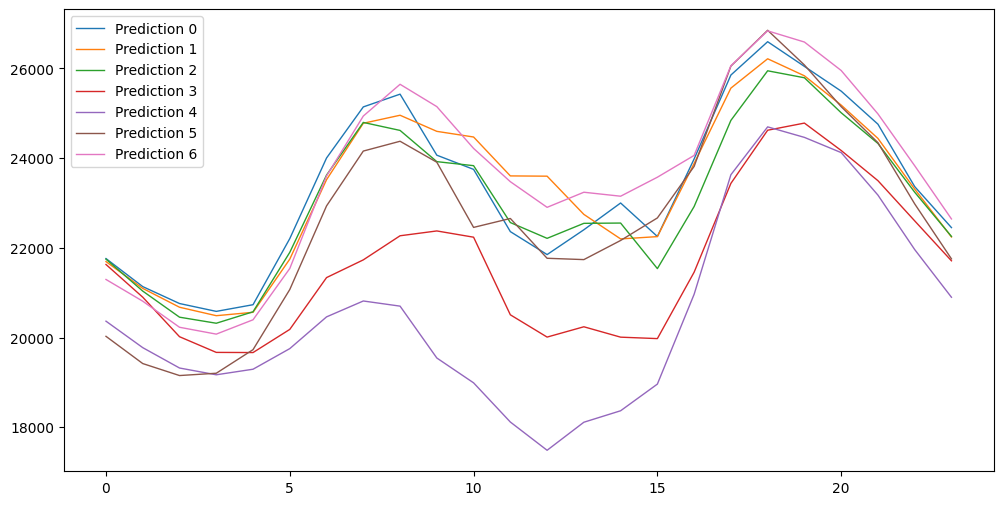

In [20]:
# predictions.append(y_pred)

plt.figure(figsize=(12, 6))
for i, y_pred in enumerate(predictions):
    # plt.plot(y_true, label="Ground Truth", linewidth=1)
    plt.plot(y_pred, label=f"Prediction {i}", linewidth=1)

# plt.title(f"Prediction for {cur_predict_date}")
plt.legend()
plt.show()

In [21]:
features_df.index[24 - 24 : 24]

DatetimeIndex(['2022-01-08 00:00:00', '2022-01-08 01:00:00',
               '2022-01-08 02:00:00', '2022-01-08 03:00:00',
               '2022-01-08 04:00:00', '2022-01-08 05:00:00',
               '2022-01-08 06:00:00', '2022-01-08 07:00:00',
               '2022-01-08 08:00:00', '2022-01-08 09:00:00',
               '2022-01-08 10:00:00', '2022-01-08 11:00:00',
               '2022-01-08 12:00:00', '2022-01-08 13:00:00',
               '2022-01-08 14:00:00', '2022-01-08 15:00:00',
               '2022-01-08 16:00:00', '2022-01-08 17:00:00',
               '2022-01-08 18:00:00', '2022-01-08 19:00:00',
               '2022-01-08 20:00:00', '2022-01-08 21:00:00',
               '2022-01-08 22:00:00', '2022-01-08 23:00:00'],
              dtype='datetime64[ns]', name='datetime', freq=None)

In [22]:
features_df.index[0]

Timestamp('2022-01-08 00:00:00')